In [30]:
import pandas as pd
import json as json
from pandas import json_normalize
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

keras.backend.clear_session()

srcDir = "../data/preprocessed/"
model_path = srcDir + "models/model_1000split_balanced/"

if not os.path.isdir(model_path):
    os.mkdir(model_path)
if not os.path.isdir(model_path + "plots/"):
    os.mkdir(model_path + "plots/")

In [33]:
# Load cleaned data

with open(srcDir + "normalized_smoothed_data.csv", 'r') as f:
    data = list(csv.reader(f))

df = pd.DataFrame(data[1:], columns=data[0])
df = df.drop(columns=["real_height","datum","smoothed_heigth"])
df["container_Id"] = df["container_id"]
df.drop(columns=["container_id"], inplace=True)
df.to_csv(os.path.join(srcDir, "training_data.csv"), index=False)
df.head()

,height_delta,temperatur_in_grad,niederschlag_in_mm,ist_industriegebiet,ist_wohngebiet,ist_feiertag,sekunde,minute,stunde,wochentag,...,DEVEUI_70B3D50070001779,DEVEUI_70B3D5007000177C,DEVEUI_70B3D50070001780,DEVEUI_70B3D50070001781,DEVEUI_70B3D50070001782,DEVEUI_70B3D50070001786,DEVEUI_70B3D50070001787,DEVEUI_70B3D50070001788,DEVEUI_70B3D50070001789,container_Id
0,0.0,0.33333334,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.0,0.8333333,...,0,0,0,0,0,0,0,0,1,77
1,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.04347826,0.8333333,...,0,0,0,0,0,0,0,0,1,77
2,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.08695652,0.8333333,...,0,0,0,0,0,0,0,0,1,77
3,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.13043478,0.8333333,...,0,0,0,0,0,0,0,0,1,77
4,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.17391305,0.8333333,...,0,0,0,0,0,0,0,0,1,77


In [32]:
df.keys()

Index(['container_id', 'height_in_cm', 'temperatur_in_grad',
       'aussentemperatur', 'niederschlag_in_mm', 'ist_industriegebiet',
       'ist_wohngebiet', 'ist_feiertag', 'datum', 'sekunde', 'minute',
       'stunde', 'wochentag', 'kalenderwoche', 'monat', 'jahr', 'farbe_brown',
       'farbe_green', 'farbe_white', 'unix_time', 'time_delta', 'hight_delta',
       'ist_ferien', 'laengengrad', 'breitengrad'],
      dtype='object')

In [3]:
len(df.loc[df["height_delta"] == "0.0"])

284899

In [4]:
# # delete height delta == 0.0
# print(len(df.loc[df["height_delta"] == "0.0"]))

# keep_rate = 4
# index = 0
# drop_list = []

# for x in range(len(df)):
#     if df["height_delta"][x] == "0.0":
#         index = index + 1
#         if not index % keep_rate == 0:
#             drop_list.append(x)

# df = df.drop(drop_list)
# print(len(df.loc[df["height_delta"] == "0.0"]))

In [5]:
df = df.loc[df["container_Id"] == "1"]
df

,height_delta,temperatur_in_grad,niederschlag_in_mm,ist_industriegebiet,ist_wohngebiet,ist_feiertag,sekunde,minute,stunde,wochentag,...,DEVEUI_70B3D50070001779,DEVEUI_70B3D5007000177C,DEVEUI_70B3D50070001780,DEVEUI_70B3D50070001781,DEVEUI_70B3D50070001782,DEVEUI_70B3D50070001786,DEVEUI_70B3D50070001787,DEVEUI_70B3D50070001788,DEVEUI_70B3D50070001789,container_Id
507731,0.0,0.1969697,0.0,0.0,1.0,0.0,0.0,0.88135594,0.0,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507732,0.0,0.16666667,0.0,0.0,1.0,0.0,1.0,0.86440676,0.04347826,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507733,0.0,0.16666667,0.0,0.0,1.0,0.0,1.0,0.86440676,0.08695652,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507734,0.0,0.1969697,0.0,0.0,1.0,0.0,1.0,0.86440676,0.13043478,0.8333333,...,0,0,0,0,0,0,0,0,0,1
507735,0.0,0.18181819,0.0,0.0,1.0,0.0,1.0,0.86440676,0.17391305,0.8333333,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515032,0.10144926,0.3030303,0.0,0.0,1.0,0.0,1.0,0.42372882,0.6956522,0.8333333,...,0,0,0,0,0,0,0,0,0,1
515033,0.04347826,0.28787878,0.0,0.0,1.0,0.0,1.0,0.42372882,0.73913044,0.8333333,...,0,0,0,0,0,0,0,0,0,1
515034,0.1014493,0.22727273,0.0,0.0,1.0,0.0,1.0,0.42372882,0.7826087,0.8333333,...,0,0,0,0,0,0,0,0,0,1
515035,0.07246378,0.25757575,0.0,0.0,1.0,0.0,0.084745765,0.44067797,0.82608694,0.8333333,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# exclude column "container_Id" at the end of dataframe
data = np.array(df.values.tolist())
data = data[:,:len(df.keys())-1]

In [8]:
# exclude every thrid sample from the training set
train = []
val = []

counter = 0
drop_rate = 1000

for x in range(len(data)):
    if counter % drop_rate == 0:
        val.append(data[x])
        counter = 0
    else:
        train.append(data[x])
    
    counter = counter + 1

In [9]:
print(len(train))
print(len(val))

train = np.array(train).astype("float32")
val = np.array(val).astype("float32")

7298
8


In [10]:
x_train = train[:, 1:]
y_train = train[:, 0]

In [11]:
x_val = val[:, 1:]
y_val = val[:, 0]

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


(7298, 97)
(7298,)
(8, 97)
(8,)


In [13]:
#
input_dim = x_train[0].shape
input_size = len(x_train[0])
batch_size = 128
no_epochs = 50
validationsplit=0.1
dropout = 0.0

In [14]:
# # # Model # #
# i = Input(shape=input_dim, name="input_layer")
# x = Dense(input_size + 40, activation="relu")(i)
# x = BatchNormalization()(x)
# x = Dense(input_size + 80, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 120, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 200, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 300, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 380, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 350, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 280, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 200, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 100, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 50, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(70, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(40, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(15, activation="relu")(x)
# x = BatchNormalization()(x)
# o = Dense(1, name="ouput_layer")(x)

# fc_model = Model(i,o, name="fc_model")
# fc_model.summary()

In [15]:
# # Model # #
i = Input(shape=input_dim, name="input_layer")
x = Dense(input_size, activation="relu")(i)
x = BatchNormalization()(x)
x = Dense(input_size, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(input_size, activation="relu")(x)
# x = BatchNormalization()(x)
o = Dense(1, name="ouput_layer")(x)

fc_model = Model(i,o, name="fc_model")
fc_model.summary()

Model: "fc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 97)]              0         
_________________________________________________________________
dense (Dense)                (None, 97)                9506      
_________________________________________________________________
batch_normalization (BatchNo (None, 97)                388       
_________________________________________________________________
dense_1 (Dense)              (None, 97)                9506      
_________________________________________________________________
batch_normalization_1 (Batch (None, 97)                388       
_________________________________________________________________
dense_2 (Dense)              (None, 97)                9506      
_________________________________________________________________
ouput_layer (Dense)          (None, 1)                 98 

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1,
                              patience=5, min_lr=0.0000001, min_delta=0.001)
#default value lr = 0.001

In [17]:
callbacks = [reduce_lr]

In [18]:
fc_model.compile(optimizer='adam', loss=mse,  metrics=["mae", "accuracy"])

# Train autoencoder
history = fc_model.fit(x_train, y_train, 
                  epochs = no_epochs,
                  shuffle=True,
                  batch_size = batch_size, 
                  validation_data=(x_val, y_val),
                  callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - 14s 11ms/step - loss: 0.1495 - mae: 0.2659 - accuracy: 0.5498 - val_loss: 0.0025 - val_mae: 0.0423 - val_accuracy: 0.5000
Epoch 2/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0198 - mae: 0.1094 - accuracy: 0.5924 - val_loss: 0.0024 - val_mae: 0.0374 - val_accuracy: 0.5000
Epoch 3/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0188 - mae: 0.1054 - accuracy: 0.5923 - val_loss: 0.0031 - val_mae: 0.0381 - val_accuracy: 0.5000
Epoch 4/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0155 - mae: 0.0974 - accuracy: 0.5909 - val_loss: 0.0056 - val_mae: 0.0659 - val_accuracy: 0.5000
Epoch 5/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0141 - mae: 0.0917 - accuracy: 0.5873 - val_loss: 0.0072 - val_mae: 0.0684 - val_accuracy: 0.5000
Epoch 6/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0102 - mae: 0.0800 - accuracy: 0.5947 - val_loss: 0.0111 - val_m

58/58 [==============================] - 0s 5ms/step - loss: 0.0017 - mae: 0.0319 - accuracy: 0.5972 - val_loss: 0.0020 - val_mae: 0.0350 - val_accuracy: 0.5000
Epoch 47/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0019 - mae: 0.0336 - accuracy: 0.5878 - val_loss: 0.0020 - val_mae: 0.0371 - val_accuracy: 0.5000
Epoch 48/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0018 - mae: 0.0329 - accuracy: 0.5969 - val_loss: 0.0020 - val_mae: 0.0345 - val_accuracy: 0.5000
Epoch 49/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0018 - mae: 0.0331 - accuracy: 0.5975 - val_loss: 0.0019 - val_mae: 0.0334 - val_accuracy: 0.5000
Epoch 50/50
58/58 [==============================] - 0s 5ms/step - loss: 0.0017 - mae: 0.0323 - accuracy: 0.5863 - val_loss: 0.0018 - val_mae: 0.0330 - val_accuracy: 0.5000


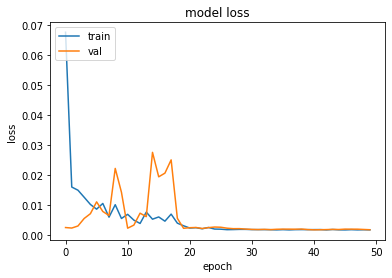

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_path + "plots/model_los.svg")
plt.show()

In [20]:
plt.close
# 254 is max height
# 134 is max delta hight

multiplier = 134

def prediction(index, x_set, y_set):
    data_point = np.array([x_set[index]])
    pred_height = fc_model.predict(data_point)[0][0] * multiplier
    real_height = y_set[index] * multiplier
    
    print("Real value: ", real_height, " estimated: ", pred_height)
    
def prediction_Plot(x_set, y_set, num):
    index_list = np.linspace(0, len(x_set)-1, num).astype("int")
    #print(index_list)
    pred_list = []
    sum_heigth = 0.0
    for x in index_list:
        data_point = np.array([x_set[x]])
        pred_height = fc_model.predict(data_point)[0][0] * multiplier
        real_height = y_set[x] * multiplier
        pred_list.append(abs(pred_height - real_height))
        sum_heigth = sum_heigth + abs(pred_height - real_height)
        
    print("Average absolute error in ", num, " data points: " , sum_heigth / num)
    plt.plot(pred_list)
    plt.ylabel('total Error')
    plt.savefig(model_path + "plots/Prediction_plot.svg")
    plt.show()

In [26]:
prediction(2, x_val, y_val)

Real value:  3.88405429944396  estimated:  1.2027454860508442


Average absolute error in  1000  data points:  3.501439028379507


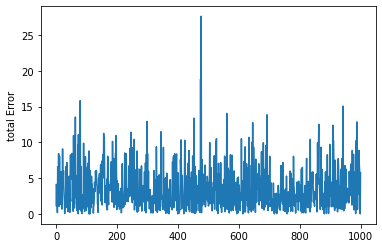

In [22]:
prediction_Plot(x_train, y_train, 1000)

In [23]:
fc_model.save(model_path + "model")

INFO:tensorflow:Assets written to: ../data/preprocessed/models/model_1000split_balanced/model/assets


In [27]:
data_in = df.values.tolist()
data_in = np.array(data_in).astype("float32")
data_in = data_in[:, 1:len(data_in[0])-1]
len(data_in[0])

97

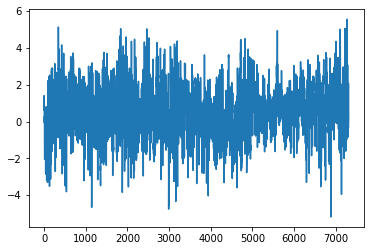

In [29]:
pp = []
for x in range(len(data_in)):
    data_point = np.array([data_in[x]])
    pred_height = fc_model.predict(data_point)[0][0] * 46
    pp.append(pred_height)
pp = np.array(pp).astype("float32")
plt.plot(pp)